# Style Transfer for raw audio.

Adopted from https://pytorch.org/tutorials/advanced/neural_style_tutorial.html

In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import IPython.display as ipd

import copy
import librosa

import matplotlib.pyplot as plt
import librosa.display
import numpy as np
from skimage import filters
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

We provide two models - `alvin_sn` and `alvin_big`. To use one over the other, Swap the model name into line 12. Alvin SN is our port of the SoundNet model. Alvin Big is our Very Deep Convolutional Neural Network that we trained. Both models are trained on the Nsynth dataset to classify pitches. You can find these models in the `./models` directory. For this example, we have loaded in the sn variant because Alvin Big does not run without CUDA.

In [3]:
import sys

def denoiseLayer(model, layer): 
    print("denoising ", layer)
    o = list()
    for i in model.state_dict()[layer]:
        f = i.cpu().detach().numpy()
        o.append(filters.gaussian(f, sigma=2))
    model.state_dict()[layer].copy_(torch.Tensor(o))

def load_model(denoise=False): 
    model = torch.load("./models/alvin_sn.pth", map_location=device)
    if denoise: 
        for ind, i in enumerate(model.children()): 
            if(ind == 0): 
                for index, j in enumerate(i): 
                    if type(j) == nn.modules.conv.Conv1d: 
                        feature_str = "features.{}.weight".format(index)
                        denoiseLayer(model, feature_str)
    return model

model = load_model()                

/Users/ashvala/anaconda3/lib/python3.7/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'Alvin.Alvin' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


We load our audio data with this function here. It returns a signal from libroas

In [4]:
def audio_loader(audio_name):
    sig, sr = librosa.load(audio_name, sr=16000)
    t = torch.Tensor(sig).unsqueeze(0)
    return t.to(device, torch.float)




In [5]:
class ContentLoss(nn.Module):
    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

This function defines a gram matrix, which is computed by multiplying a matrix by its transpose. 

In [6]:
def gram_matrix(input):
    #print(input.size())
    a, b, c = input.size()  # a is batch size. b is number of features and c is the dimension of our feature map

    features = input.view(a * b, c)  # resize 

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c)

In [7]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

We normalized to mean 0 and std_dev 1. This is what we use to normalize our "image"

In [8]:
cnn = model.features.to(device).eval()
cnn_normalization_mean = torch.tensor([0.0]).to(device)
cnn_normalization_std = torch.tensor([1.0]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1,1)
        self.std = torch.tensor(std).view(-1, 1,1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

As a debugging measure, we implemented a Printing Layer that allowed us to print the size of the outputs from the preceeding layer in our neural networks. This is here to ensure that the next step in our notebook does not fail. 

Credit for this function: https://discuss.pytorch.org/t/how-do-i-print-output-of-each-layer-in-sequential/5773/3

In [27]:
class PrintLayer(nn.Module):
        def __init__(self, id_str):
            self.id_str = id_str
            super(PrintLayer, self).__init__()

        def forward(self, x):
            # Do your print / debug stuff here
#            print(self.id_str, x.size())
            return x

From the tutorial:

A Sequential module contains an ordered list of child modules. For instance, `vgg19.features` contains a sequence (Conv2d, ReLU, MaxPool2d, Conv2d, ReLU…) aligned in the right order of depth. We need to add our content loss and style loss layers immediately after the convolution layer they are detecting. To do this we must create a new Sequential module that has content loss and style loss modules correctly inserted.

In [30]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_7']
style_layers_default = ['conv_1', 'conv_2']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []
    style_img = style_img.unsqueeze(0)
    content_img = content_img.unsqueeze(0)
    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv1d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool1d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm1d):
            name = 'bn_{}'.format(i)
        elif isinstance(layer, nn.AvgPool1d):
            name = 'apool_{}'.format(i)
        elif isinstance(layer, PrintLayer): 
            name = 'pl_{}'.format(i)
        else:
            print(layer)
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img)
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img)
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]
     
    return model, style_losses, content_losses

From the tutorial: 

As Leon Gatys, the author of the algorithm, suggested [here](https://discuss.pytorch.org/t/pytorch-tutorial-for-neural-transfert-of-artistic-style/336/20?u=alexis-jacq), we will use L-BFGS algorithm to run our gradient descent. Unlike training a network, we want to train the input image in order to minimise the content/style losses. We will create a PyTorch L-BFGS optimizer optim.LBFGS and pass our image to it as the tensor to optimize.

In [11]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

From the tutorial: 

Finally, we must define a function that performs the neural transfer. For each iteration of the networks, it is fed an updated input and computes new losses. We will run the backward methods of each loss module to dynamicaly compute their gradients. The optimizer requires a “closure” function, which reevaluates the modul and returns the loss.

In [12]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=3000,
                       style_weight=100000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')

    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            # input_img.data.clamp_(-1.0, 1.0)
            # print("num_steps", run[0])
            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 100 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    # input_img.data.clamp_(-1.0, 1.0)

    return input_img

Load your audio files that are of the same length here.

In [13]:
style_img = audio_loader("./test_data/Alexa.wav")
content_img = audio_loader("./test_data/Doorbell.wav")

input_img = content_img.clone()

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

In [14]:
# here are the originals
# Style audio
ipd.Audio(data=style_img.cpu().detach().numpy()[0], rate=16000)

In [15]:
# content audio
ipd.Audio(data=content_img.cpu().detach().numpy()[0], rate=16000)

In [17]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps=300)

Building the style transfer model..
Optimizing..


/Users/ashvala/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/Users/ashvala/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


run [100]:
Style Loss : 3.351283 Content Loss: 1.784483

run [200]:
Style Loss : 0.945942 Content Loss: 1.570383

run [300]:
Style Loss : 0.403388 Content Loss: 1.344568



In [18]:
ipd.Audio(data=output.cpu().detach().numpy()[0], rate=16000)

In [19]:
output_spect = np.abs(librosa.stft(output.cpu().detach().numpy()[0], n_fft=2048, hop_length=1024))

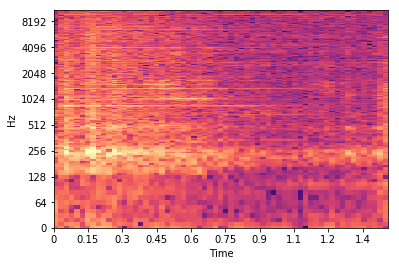

In [20]:
librosa.display.specshow(librosa.power_to_db(output_spect, ref=np.max), y_axis="log", x_axis="time")

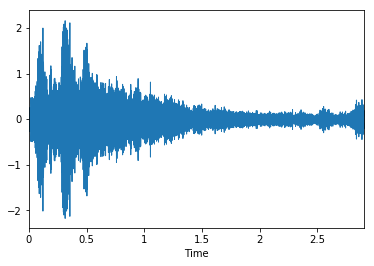

In [21]:
librosa.display.waveplot(output.cpu().detach().numpy()[0])

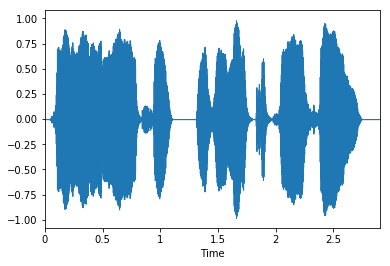

In [22]:
librosa.display.waveplot(style_img.cpu().detach().numpy()[0])

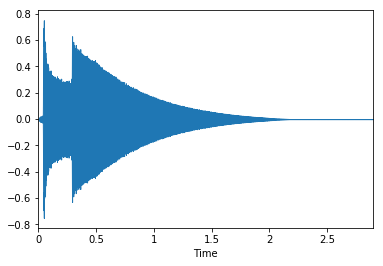

In [23]:
librosa.display.waveplot(content_img.cpu().detach().numpy()[0])

In [24]:
print(model)

Alvin(
  (features): Sequential(
    (0): Conv1d(1, 16, kernel_size=(64,), stride=(2,), padding=(32,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool1d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(16, 32, kernel_size=(128,), stride=(2,), padding=(16,))
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace)
    (7): MaxPool1d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
    (8): Conv1d(32, 64, kernel_size=(16,), stride=(2,), padding=(8,))
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace)
    (11): Conv1d(64, 128, kernel_size=(8,), stride=(2,), padding=(4,))
    (12): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace)
    (14): Conv1d(128, 256, kernel_size=(4,), stride=(2,), paddin

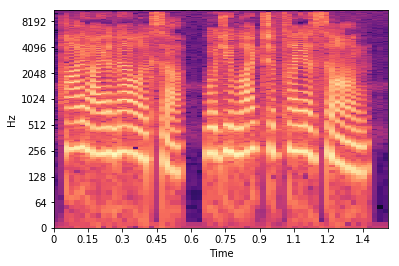

In [25]:
output_spect2 = np.abs(librosa.stft(style_img.cpu().detach().numpy()[0], n_fft=2048, hop_length=1024))
librosa.display.specshow(librosa.power_to_db(output_spect2, ref=np.max), y_axis="log", x_axis="time")

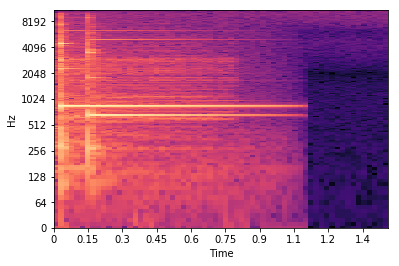

In [29]:
output_spect3 = np.abs(librosa.stft(content_img.cpu().detach().numpy()[0], n_fft=2048, hop_length=1024))
librosa.display.specshow(librosa.power_to_db(output_spect3, ref=np.max), y_axis="log", x_axis="time")